<a href="https://www.kaggle.com/code/krishnadeshpande2907/emotional-analysis-of-audio-lstm?scriptVersionId=206458252" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing Modules

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import random
import torch
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Loading the Dataset

In [ ]:
# Paths for data.
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"
# IEMOCAP = ""

## TESS

In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])


In [ ]:
# Joining them both
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

In [ ]:
sns.countplot(data=Tess_df, x='Emotions')

In [ ]:
# Sample Audio
path = np.array(Tess_df.Path)[1]
data, sample_rate = librosa.load(path)

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

## Ravdess

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])

In [ ]:
# Joining them both
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

In [ ]:
sns.countplot(data=Ravdess_df, x='Emotions')

In [ ]:
# Sample Audio
path = np.array(Ravdess_df.Path)[1]
data, sample_rate = librosa.load(path)

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

## Crema-D

In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])

In [ ]:
# Joining them both
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

In [ ]:
sns.countplot(data=Crema_df, x='Emotions')

In [ ]:
# Sample Audio
path = np.array(Crema_df.Path)[1]
data, sample_rate = librosa.load(path)

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

## Savee

In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])

In [ ]:
# Joining them both
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

In [ ]:
sns.countplot(data=Savee_df, x='Emotions')

In [ ]:
# Sample Audio
path = np.array(Savee_df.Path)[1]
data, sample_rate = librosa.load(path)

plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

## Combining All

In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.shape

In [ ]:
data_path.head()

In [ ]:
sns.countplot(data=data_path, x='Emotions')

In [ ]:
data_path['Emotions'].value_counts()

# Data Pre-Processing

## Exploring the Labels

In [ ]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

### Fear

In [ ]:
emotion = 'fear'
path = np.array(data_path['Path'][data_path['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

### Anger

In [ ]:
emotion = 'angry'
path = np.array(data_path['Path'][data_path['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

### Disgust

In [ ]:
emotion = 'disgust'
path = np.array(data_path['Path'][data_path['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

### Neutral

In [ ]:
emotion = 'neutral'
path = np.array(data_path['Path'][data_path['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

### Sad

In [ ]:
emotion = 'sad'
path = np.array(data_path['Path'][data_path['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

### Happy

In [ ]:
emotion = 'happy'
path = np.array(data_path['Path'][data_path['Emotions']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

## Removing Error causing possibilities

In [4]:
data_path = data_path[data_path['Emotions'] != 'calm']
data_path

NameError: name 'data_path' is not defined

In [ ]:
sns.countplot(data=data_path, x='Emotions')

## Shuffling

In [ ]:
data_path = data_path.sample(frac=1)
data_path.head()

In [ ]:
data_path['Emotions'].value_counts()

* Lets get even here... 
* We will use upsampling and downsampling both here
* We will keep 1800 of other emotions of the dataset and increase the number of neutral emotions.
* Let's remove the number of surprises we have for now...


## Deleting till 1800

In [ ]:
# Emotions to reduce
emotions_to_reduce = ['fear', 'angry', 'happy', 'disgust', 'sad']

# Separate out the rows for emotions
reduced_data = (
    data_path[data_path['Emotions'].isin(emotions_to_reduce)]
    .groupby('Emotions')
    .head(1800)  # Keep only the first 1800 samples for these emotions
)

# Keep all samples for emotions not in emotions_to_reduce
other_data = data_path[~data_path['Emotions'].isin(emotions_to_reduce)]

# Combine the reduced emotions and the other emotions
data_path = pd.concat([reduced_data, other_data], ignore_index=True)


In [ ]:
data_path['Emotions'].value_counts()

In [ ]:
data_path.Emotions.describe()

## Removing the Surprises

In [ ]:
data_path = data_path[data_path['Emotions'] != 'surprises']
sns.countplot(data=data_path, x='Emotions')

## Duplicating Neutral Emotion Audio Samples
* We can duplicate a few random audio samples of Neutral Emotion till the count reaches that of the others

In [ ]:
neutral_data = data_path[data_path['Emotions'] == 'neutral']
duplicates_needed = 1800 - len(neutral_data)
neutral_augmented = neutral_data.sample(duplicates_needed, replace=True, random_state=42)

# Combine the original and duplicated 'neutral' data
balanced_neutral_data = pd.concat([neutral_data, neutral_augmented])

# Combine all the balanced data
data_path = pd.concat([reduced_data, balanced_neutral_data])

## Verifying Count

In [ ]:
print(data_path['Emotions'].value_counts())

In [ ]:
sns.countplot(data=data_path, x='Emotions')

## Data Augmentation

In [ ]:
# Function for adding noise to audio
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# Function for stretching the audio
def stretch(data, rate):
    return librosa.effects.time_stretch(data, rate=rate)

# Function for shifting the audio
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

# Function for adding pitch to audio
def pitch(data, sampling_rate, pitch_factor):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor*12)

In [ ]:
# taking any example and checking for the techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)
# data and sample_rate = diff per path

### 1. Noise Injection

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### 2. Stretching
* Changing speed

In [2]:
x = stretch(data, 0.7)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

NameError: name 'stretch' is not defined

### 3. Shifting

In [3]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

NameError: name 'shift' is not defined

### 4. Pitch

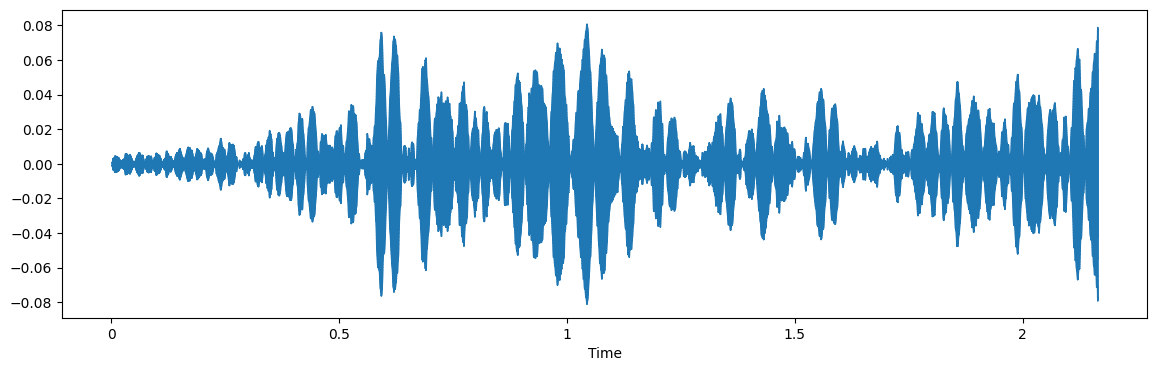

In [53]:
x = pitch(data, sample_rate, pitch_factor=np.random.uniform(-5, 5))
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# Data Preprocessing

## Feature Extraction

In [56]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    return result

In [57]:
def augment_and_extract_features(path, n_augment=100):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # Extract features from the original audio
    original_features = extract_features(data, sample_rate)

    # Randomly choose an augmentation technique
    augmentation_methods = [noise, stretch, shift, pitch]
    method = random.choice(augmentation_methods)

    # Apply the chosen augmentation
    if method == pitch:
        augmented_data = method(data, sample_rate, pitch_factor=np.random.uniform(-5, 5))
    elif method == stretch:
        augmented_data = method(data, rate=np.random.uniform(0.5, 1.5))
    else:
        augmented_data = method(data)

    # Extract features from the augmented audio
    augmented_features = extract_features(augmented_data, sample_rate)

    # Stack original and augmented features vertically
    combined_features = np.vstack((original_features, augmented_features))

    return combined_features

In [ ]:
# Dataset processing
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    features = augment_and_extract_features(path)
    for feature in features:
        X.append(feature)
        Y.append(emotion)

X = np.array(X)
Y = np.array(Y)

# Shuffle the dataset
X, Y = shuffle(X, Y, random_state=42)

In [65]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Reshape for LSTM (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

splitting it in the ratio 3:1

In [68]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16200, 162), (16200, 6), (5400, 162), (5400, 6))

# LSTM Model

In [ ]:
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(X.shape[1],1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
# Train the model
history = model.fit(x_train, y_train, 
                    validation_data=(x_test, y_test), epochs=80, batch_size=64)

## Plot the results

In [ ]:
epochs = list(range(80))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Predict

In [ ]:
y_train = model.predict(x_train)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

## Accuracy

In [ ]:
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {accuracy:.2f}")

## Confusion Matrix

In [ ]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

## ROC-AUC Curve

In [ ]:
y_test_bin = label_binarize(y_true_classes, classes=range(6))  # Replace 7 with the number of classes
n_classes = y_test_bin.shape[1]

In [ ]:
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Each Class")
plt.legend(loc="lower right")
plt.show()